## Processing playground 
### tracking neurons across days 

In [3]:
%load_ext autoreload
%autoreload 

import UnitMatchPy.bayes_functions as bf
import UnitMatchPy.utils as util
import UnitMatchPy.overlord as ov
import numpy as np
import matplotlib.pyplot as plt
import UnitMatchPy.save_utils as su
import UnitMatchPy.GUI as gui
import UnitMatchPy.assign_unique_id as aid
import UnitMatchPy.default_params as default_params

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:

## Step 1: Set up file paths
# Get default parameters, can add your own before or after!
param = default_params.get_default_param()
# KiloSort directories - USE SAME SESSION TWICE for merge/split testing
# loop for animals in cta_backwards directory starting with calca_2 ot calca_3. use two last day folders inside. 
KS_dirs = [r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/kilosort4',
           r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/kilosort4']  # Same session repeated
param['KS_dirs'] = KS_dirs

# BombCell output directories - USE SAME SESSION TWICE  
custom_bombcell_paths = [r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf/cluster_bc_unitType.tsv',
                         r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf/cluster_bc_unitType.tsv']  # Same session repeated

custom_raw_waveform_paths = [r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-19/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf/RawWaveforms', 
                             r'/home/jf5479/cup/Chris/data/cta_backwards/calca_302/2023-04-20/cz_npxl_g0/cz_npxl_g0_imec0/bombcell_testing_jf/RawWaveforms']
wave_paths, unit_label_paths, channel_pos = util.paths_from_KS(
    KS_dirs, 
    custom_raw_waveform_paths=custom_raw_waveform_paths,
    custom_bombcell_paths=custom_bombcell_paths
)

param = util.get_probe_geometry(channel_pos[0], param)

In [9]:
# STEP 0 -- data preparation
# Read in data and select the good units and exact metadata
waveform, session_id, session_switch, within_session, good_units, param = util.load_good_waveforms(wave_paths, unit_label_paths, param, good_units_only = True) 

# param['peak_loc'] = #may need to set as a value if the peak location is NOT ~ half the spike width

# Create clus_info, contains all unit id/session related info
clus_info = {'good_units' : good_units, 'session_switch' : session_switch, 'session_id' : session_id, 
            'original_ids' : np.concatenate(good_units) }

# STEP 1
# Extract parameters from waveform
extracted_wave_properties = ov.extract_parameters(waveform, channel_pos, clus_info, param)

# STEP 2, 3, 4
# Extract metric scores
total_score, candidate_pairs, scores_to_include, predictors  = ov.extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, niter  = 2)

# STEP 5
# Probability analysis
# Get prior probability of being a match
prior_match = 1 - (param['n_expected_matches'] / param['n_units']**2 ) # freedom of choose in prior prob
priors = np.array((prior_match, 1-prior_match))

# Construct distributions (kernels) for Naive Bayes Classifier
labels = candidate_pairs.astype(int)
cond = np.unique(labels)
score_vector = param['score_vector']
parameter_kernels = np.full((len(score_vector), len(scores_to_include), len(cond)), np.nan)

parameter_kernels = bf.get_parameter_kernels(scores_to_include, labels, cond, param, add_one = 1)

# Get probability of each pair of being a match
probability = bf.apply_naive_bayes(parameter_kernels, priors, predictors, param, cond)

output_prob_matrix = probability[:,1].reshape(param['n_units'],param['n_units'])

Calculating the probability distributions of the metric scores
Calculating the match probabilities


The percentage of units matched to themselves is: 69.50819672131148%
The percentage of false -ve's then is: 30.491803278688522% 

The rate of miss-match(es) per expected match 0.08852459016393442
The percentage of false +ve's is 0.06613131790269249% for session 1
The percentage of false +ve's is 0.05174747233500517% for session 2

This assumes that the spike sorter has made no mistakes


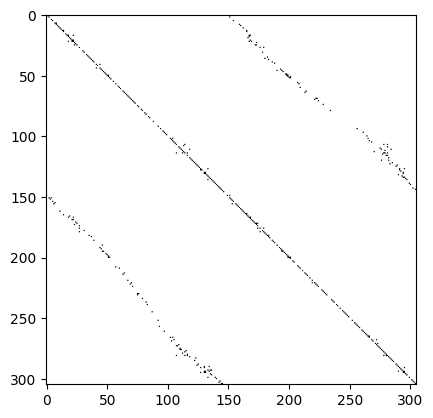

In [10]:
util.evaluate_output(output_prob_matrix, param, within_session, session_switch, match_threshold = 0.75)

match_threshold = param['match_threshold']
# match_threshold = try different values here!

output_threshold = np.zeros_like(output_prob_matrix)
output_threshold[output_prob_matrix > match_threshold] = 1

plt.imshow(output_threshold, cmap = 'Greys')


In [11]:
# STEP 6
# Format data for GUI
amplitude = extracted_wave_properties['amplitude']
spatial_decay = extracted_wave_properties['spatial_decay']
avg_centroid = extracted_wave_properties['avg_centroid']
avg_waveform = extracted_wave_properties['avg_waveform']
avg_waveform_per_tp = extracted_wave_properties['avg_waveform_per_tp']
wave_idx = extracted_wave_properties['good_wave_idxs']
max_site = extracted_wave_properties['max_site']
max_site_mean = extracted_wave_properties['max_site_mean']
gui.process_info_for_GUI(output_prob_matrix, match_threshold, scores_to_include, total_score, amplitude, spatial_decay,
                         avg_centroid, avg_waveform, avg_waveform_per_tp, wave_idx, max_site, max_site_mean, 
                         waveform, within_session, channel_pos, clus_info, param)


In [12]:
## Step 5: UnitMatch - Metric Calculation and Drift Correction
print("Calculating similarity metrics and applying drift correction...")

# Temporarily patch the UnitMatch overlord function to debug the quantile issue
import UnitMatchPy.overlord as ov_original
import UnitMatchPy.metric_functions as mf

def patched_extract_metric_scores(extracted_wave_properties, session_switch, within_session, param, niter=2):
    """Patched version with debugging for quantile issue"""
    import numpy as np
    
    # Unpack needed arrays from the ExtractedWaveProperties dictionary
    amplitude = extracted_wave_properties['amplitude']
    spatial_decay = extracted_wave_properties['spatial_decay']
    spatial_decay_fit = extracted_wave_properties['spatial_decay_fit']
    avg_waveform = extracted_wave_properties['avg_waveform']
    avg_waveform_per_tp = extracted_wave_properties['avg_waveform_per_tp']
    avg_centroid = extracted_wave_properties['avg_centroid']

    # These scores are NOT affected by the drift correction
    amp_score = mf.get_simple_metric(amplitude)
    spatial_decay_score = mf.get_simple_metric(spatial_decay)
    spatial_decay_fit_score = mf.get_simple_metric(spatial_decay_fit, outlier=True)
    wave_corr_score = mf.get_wave_corr(avg_waveform, param)
    wave_mse_score = mf.get_waveforms_mse(avg_waveform, param)

    # Affected by drift
    for i in range(niter):
        avg_waveform_per_tp_flip = mf.flip_dim(avg_waveform_per_tp, param)
        euclid_dist = mf.get_Euclidean_dist(avg_waveform_per_tp_flip, param)

        centroid_dist, centroid_var = mf.centroid_metrics(euclid_dist, param)

        euclid_dist_rc = mf.get_recentered_euclidean_dist(avg_waveform_per_tp_flip, avg_centroid, param)

        centroid_dist_recentered = mf.recentered_metrics(euclid_dist_rc)
        traj_angle_score, traj_dist_score = mf.dist_angle(avg_waveform_per_tp_flip, param)

        # Average Euc Dist
        euclid_dist = np.nanmin(euclid_dist[:,param['peak_loc'] - param['waveidx'] == 0, :,:].squeeze(), axis=1)

        # TotalScore
        include_these_pairs = np.argwhere(euclid_dist < param['max_dist'])  # array indices of pairs to include
        include_these_pairs_idx = np.zeros_like(euclid_dist)
        include_these_pairs_idx[euclid_dist < param['max_dist']] = 1

        # Make a dictionary of score to include
        centroid_overlord_score = (centroid_dist_recentered + centroid_var) / 2
        waveform_score = (wave_corr_score + wave_mse_score) / 2
        trajectory_score = (traj_angle_score + traj_dist_score) / 2

        scores_to_include = {'amp_score': amp_score, 'spatial_decay_score': spatial_decay_score, 'centroid_overlord_score': centroid_overlord_score,
                            'centroid_dist': centroid_dist, 'waveform_score': waveform_score, 'trajectory_score': trajectory_score}

        total_score, predictors = mf.get_total_score(scores_to_include, param)

        # Initial thresholding
        if (i < niter - 1):
            # Get the threshold for a match
            thrs_opt = mf.get_threshold(total_score, within_session, euclid_dist, param, is_first_pass=True)

            param['n_expected_matches'] = np.sum((total_score > thrs_opt).astype(int))
            prior_match = 1 - (param['n_expected_matches'] / len(include_these_pairs))
            candidate_pairs = total_score > thrs_opt

            drifts, avg_centroid, avg_waveform_per_tp = mf.drift_n_sessions(candidate_pairs, session_switch, avg_centroid, avg_waveform_per_tp, total_score, param)

    # Final threshold calculation with debugging
    thrs_opt = mf.get_threshold(total_score, within_session, euclid_dist, param, is_first_pass=False)
    param['n_expected_matches'] = np.sum((total_score > thrs_opt).astype(int))
    prior_match = 1 - (param['n_expected_matches'] / len(include_these_pairs))
    
    # Debug: Let's examine the total_score and prior_match values
    print(f"Debug patched function:")
    print(f"include_these_pairs length: {len(include_these_pairs)}")
    print(f"n_expected_matches: {param['n_expected_matches']}")
    print(f"prior_match calculation: 1 - ({param['n_expected_matches']} / {len(include_these_pairs)}) = {prior_match}")
    print(f"prior_match value: {prior_match}")
    print(f"prior_match type: {type(prior_match)}")
    print(f"Is prior_match finite: {np.isfinite(prior_match)}")
    print(f"total_score shape: {total_score.shape}")
    print(f"include_these_pairs_idx sum: {np.sum(include_these_pairs_idx.astype(bool))}")
    print(f"total_score[include_these_pairs_idx.astype(bool)] shape: {total_score[include_these_pairs_idx.astype(bool)].shape}")
    
    if len(include_these_pairs) > 0:
        print(f"total_score min: {np.min(total_score[include_these_pairs_idx.astype(bool)])}")
        print(f"total_score max: {np.max(total_score[include_these_pairs_idx.astype(bool)])}")
    
    # Original problematic line that we're trying to debug
    try:
        thrs_opt = np.quantile(total_score[include_these_pairs_idx.astype(bool)], prior_match)
        print(f"Quantile calculation succeeded: {thrs_opt}")
    except Exception as e:
        print(f"Quantile calculation failed: {e}")
        # Let's try to understand what's wrong
        if not (0 <= prior_match <= 1):
            print("prior_match is outside [0,1] range!")
            if prior_match < 0:
                print("prior_match is negative - using 0.0 instead")
                prior_match = 0.0
            elif prior_match > 1:
                print("prior_match is greater than 1 - using 1.0 instead")
                prior_match = 1.0
            
            try:
                thrs_opt = np.quantile(total_score[include_these_pairs_idx.astype(bool)], prior_match)
                print(f"Quantile calculation with corrected prior_match succeeded: {thrs_opt}")
            except Exception as e2:
                print(f"Quantile calculation still failed: {e2}")
                thrs_opt = np.median(total_score[include_these_pairs_idx.astype(bool)])
                print(f"Using median as fallback: {thrs_opt}")
    
    candidate_pairs = total_score > thrs_opt
    return total_score, candidate_pairs, scores_to_include, predictors

# Use the patched function
try:
    total_score, candidate_pairs, scores_to_include, predictors = patched_extract_metric_scores(
        extracted_wave_properties, session_switch, within_session, param, niter=2
    )

    print(f"SUCCESS: Number of candidate pairs: {np.sum(candidate_pairs)}")
    print(f"Scores included: {list(scores_to_include.keys())}")
    print("Metric calculation and drift correction complete.")
    
except Exception as e:
    print(f"ERROR in patched function: {e}")
    import traceback
    traceback.print_exc()

Calculating similarity metrics and applying drift correction...
Debug patched function:
include_these_pairs length: 8519
n_expected_matches: 581
prior_match calculation: 1 - (581 / 8519) = 0.9317995069843878
prior_match value: 0.9317995069843878
prior_match type: <class 'numpy.float64'>
Is prior_match finite: True
total_score shape: (305, 305)
include_these_pairs_idx sum: 8519
total_score[include_these_pairs_idx.astype(bool)] shape: (8519,)
total_score min: 0.06936152845790065
total_score max: 1.0
Quantile calculation succeeded: 0.7447032168566696
SUCCESS: Number of candidate pairs: 581
Scores included: ['amp_score', 'spatial_decay_score', 'centroid_overlord_score', 'centroid_dist', 'waveform_score', 'trajectory_score']
Metric calculation and drift correction complete.


In [16]:
param['n_units']
param['n_units_per_session']

[657, 644]

In [14]:
# Run GUI
is_match, not_match, matches_GUI = gui.run_GUI()

Icon path: /home/jf5479/Dropbox/Python/UnitMatch/UnitMatchPy/UnitMatchPy/GUI_icon.png
File exists: True


In [ ]:
matches_curated = util.curate_matches(matches_GUI, is_match, not_match, mode = 'And')

In [ ]:
matches = np.argwhere(output_threshold == 1)
UIDs = aid.assign_unique_id(output_prob_matrix, param, clus_info)

save_dir = r'Path/to/save/dir'
#NOTE - change to matches to matches_curated if done manual curation with the GUI
su.save_to_output(save_dir, scores_to_include, matches # matches_curated
                  , output_prob_matrix, avg_centroid, avg_waveform, avg_waveform_per_tp, max_site,
                   total_score, output_threshold, clus_info, param, UIDs = UIDs, matches_curated = None, save_match_table = True)

In [17]:
#all idx pairs where the probability is above the threshold
matches_within_session = np.argwhere(output_threshold == 1) #include within session matches
matches = np.argwhere( ((output_threshold * within_session)) == True) #exclude within session matches

#this function has 2 mode 'and' 'or', which returns a matches if they appear in both or one cv pair
#then it will add all the matches selected as IsMaatch, then remove all matches in NotMatch
matches_curated = util.curate_matches(matches_GUI, is_match, not_match, mode = 'and')


There are no curated matches/none matches


In [20]:
np.size(matches)
np.size(matches_within_session)

950